In [15]:
#Importing Library

import os
import warnings

from pmdarima import c
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [16]:
#from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [33]:
#Importing ADBL csv file

dateparse = lambda dates: pd.datetime.strptime(dates,"%Y-%m-%d")
data = pd.read_csv('ADBL.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
data.head()

,LTP,Open,High,Low,Quantity,Turnover
Date,,,,,,
2011-03-25,135,133.0,135.0,132.0,2560,342820
2011-03-27,134,135.0,135.0,134.0,2110,284040
2011-03-28,130,134.0,134.0,130.0,1288,169336
2011-03-29,127,130.0,129.0,127.0,1390,178760
2011-03-30,129,127.0,129.0,125.0,1261,161332


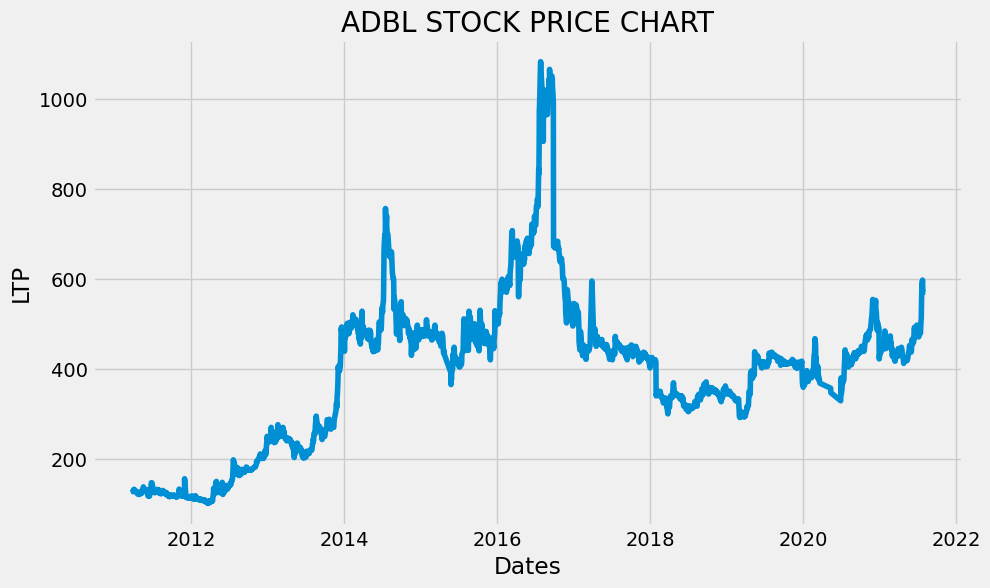

In [18]:
#plot closing price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('LTP')
plt.plot(data['LTP'])
plt.title('ADBL STOCK PRICE CHART')
plt.show()

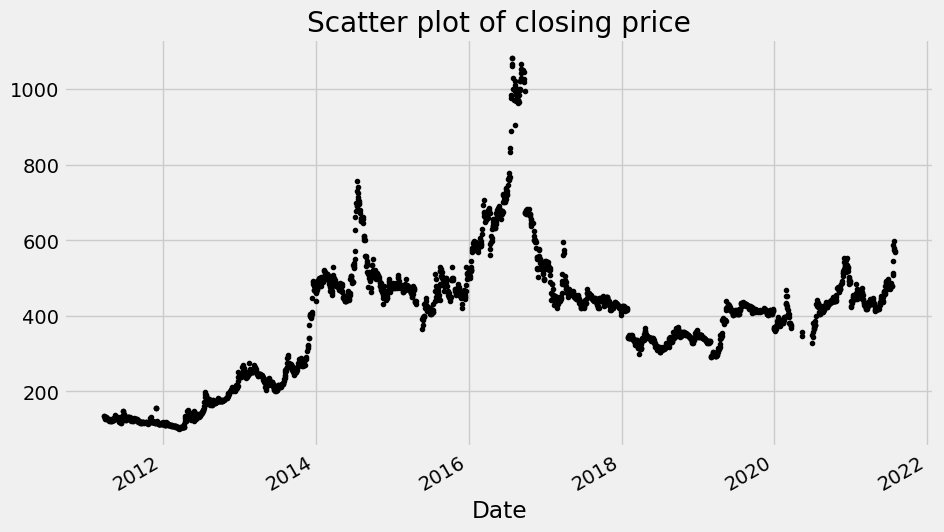

In [19]:
#scatter plot of closing price
df_close = data['LTP']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

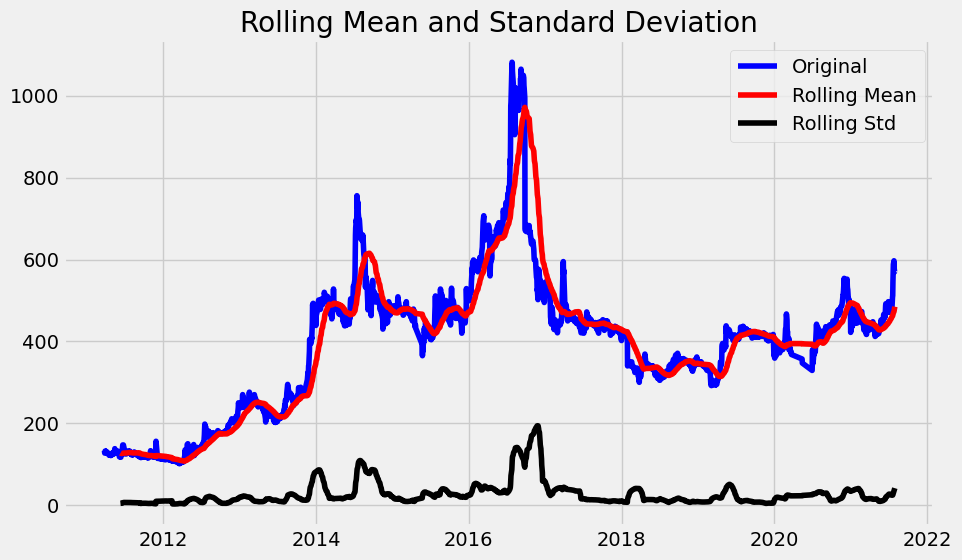

Results of dickey fuller test
Test Statistics                  -2.106292
p-value                           0.241992
No. of lags used                  1.000000
Number of observations used    2348.000000
critical value (1%)              -3.433138
critical value (5%)              -2.862772
critical value (10%)             -2.567426
dtype: float64


In [20]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(50).mean()
    rolstd = timeseries.rolling(50).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

<Figure size 1000x600 with 0 Axes>

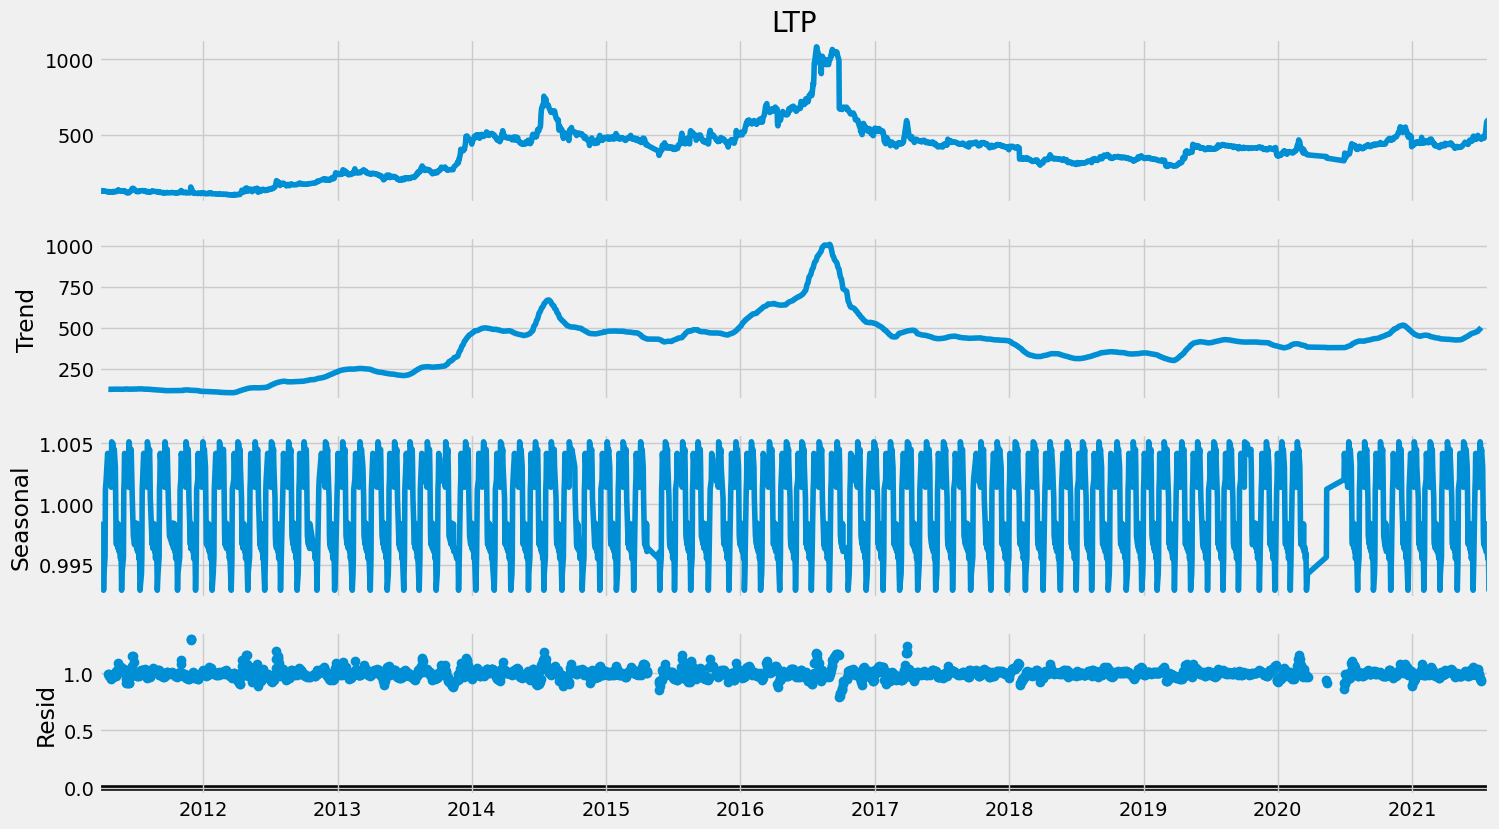

In [21]:
#decomposition of data
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


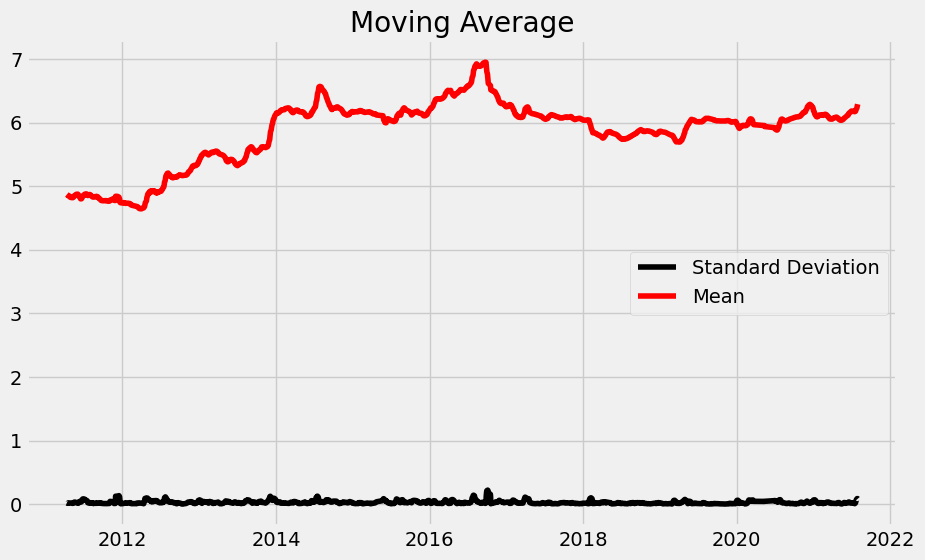

In [22]:
#calculation of moving average
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [23]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.75)], df_log[int(len(df_log)*0.75):]

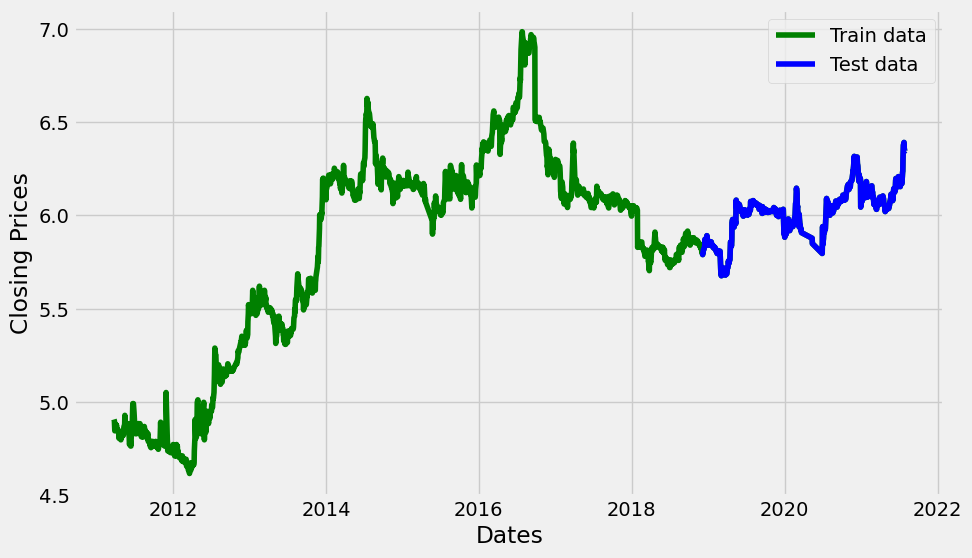

In [24]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
y = np.exp(test_data)

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1759
Model:             SARIMAX(0, 1, 3)x(0, 0, [1], 4)   Log Likelihood                3783.256
Date:                             Tue, 19 Sep 2023   AIC                          -7556.512
Time:                                     22:08:09   BIC                          -7529.153
Sample:                                          0   HQIC                         -7546.401
                                            - 1759                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0762      0.019      3.927      0.000       0.038       0.114
ma.L2         -0.0227      

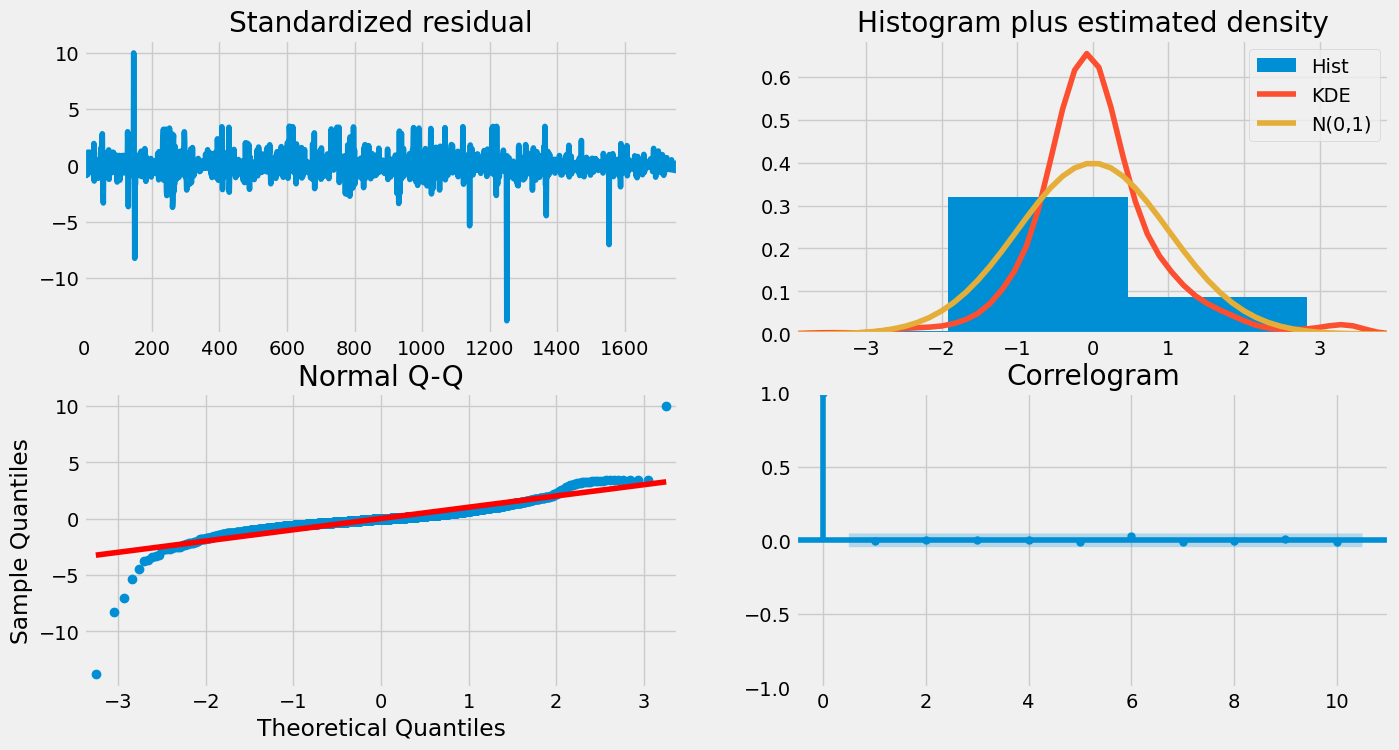

In [40]:
#build arima model
forecaster = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=4,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                   start_P=0, 
                      D=0, 
           
                  error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


forecaster.summary()

print(forecaster.summary())

forecaster.plot_diagnostics(figsize=(15,8))
plt.show()

In [48]:
#Traning ARIMA 
model = sm.tsa.arima.ARIMA(train_data, order=(0, 1, 3))  
fitted = model.fit()  
print(fitted)
#print(fitted.summary())
print(df.columns)

from statsmodels.tsa.stattools import acf
train_data = df.value[:85]
test_data= df.value[85:]
 #Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Train Data')
plt.plot(test_data, color = 'blue', label='Actual Test Data')
plt.plot(fc_series, color = 'orange',label='Predicted Test Data')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
x = np.exp(fc_series)
#print(x)
plt.title('ADBL STOCK PRICE CHART')
plt.xlabel('Time')
plt.ylabel('LTP')
plt.legend(loc='upper left', fontsize=8)
plt.show()

x.plot(legend = True, label = 'Predicted Stock Price')
y.plot(legend = True, label = 'Actual Stock Price')

from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(x,y))
print(rmse)

print(y.mean())

Index(['LTP', 'Open', 'High', 'Low', 'Quantity', 'Turnover'], dtype='object')


ValueError: too many values to unpack (expected 3)

In [ ]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

final_arima = sm.tsa.arima.ARIMA(data['LTP'], order = (0,1,3))
model = final_arima.fit()
data.tail()

In [ ]:
index_future_dates = pd.date_range(start = '2021-07-29', end = '2021-08-10')
print(index_future_dates)
pred = model.predict(start = len(data), end = len(data)+12, typ = 'levels').rename('ARIMA Prediction')
pred.index = index_future_dates
print(pred)
df = pd.concat([data, pred])
df.tail()

In [ ]:
pred.plot(figsize= (12, 5),color = 'green', legend = True)

train = data[:len(train_data)]
valid = data[len(train_data):]
valid['Predictions'] = pred
valid['predd'] = x
plt.figure(figsize = (40, 10 ))
plt.title("Model")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("LTP", fontsize = 18)
plt.plot(train['LTP'], color = "black")

plt.plot(valid['LTP'], color = "red")

plt.plot(pred, color = "green")
plt.legend(['Train', 'Test', 'Predicted'], loc = 'upper right')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt
print(data)

data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
print(data)
fig = go.Figure([go.Scatter(x=data['Date'], y=data['LTP'])])
fig.show()